# Để xây dựng mô hình dự báo biến động giá cổ phiếu, em sẽ sử dụng phương pháp LSTM (mạng neuron dài và ngắn)

In [1]:
import pandas as pd # Đọc và xử lý dữ liệu
import numpy as np # Xử lý dữ liệu
from datetime import datetime as datetime # Chỉnh dữ liệu thời gian
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import LSTM # Học phụ thuộc
from keras.layers import Dropout # Tránh học tủ
from keras.layers import Dense # Đầu ra




# Kiểm định độ chính xác của mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo phần trăm sai số tuyệt đối trung bình

# Đọc, xử lý và biến đổi dữ liệu

In [8]:
df = pd.read_csv('FPT.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [9]:
# Thông tin bộ dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


=> Không có dữ liệu khuyết thiếu

In [10]:
# Mô tả bộ dữ liệu
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


In [11]:
df['Date/Time'] = pd.to_datetime(df["Date/Time"]) # chỉnh kiểu dữ liệu của cột Date/Time
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,0
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,0
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0


In [12]:
# Tạo list ngày tháng năm
Date = []
for i in df['Date/Time']:
    if datetime.strftime(i,"%Y-%m-%d") not in Date:
        Date.append(datetime.strftime(i,"%Y-%m-%d"))
print(Date)

['2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019

In [13]:
# Tạo list giá mở cửa, đóng cửa, cao nhất, thấp nhất
Open = []
High = []
Low = []
Close = []
for date in Date:
    subset = df[df['Date/Time'].dt.date == datetime.strptime(date, '%Y-%m-%d').date()]
    Open.append(subset.iloc[0]['Open'])
    High.append(subset['High'].max())
    Low.append(subset['Low'].min())
    Close.append(subset.iloc[-1]['Close'])

In [14]:
# Tạo 1 dataframe chứa dữ liệu giao dịch theo từng ngày
price_data_series = {
    'Tiker':df['Ticker'][:len(Date)],
    'Date': Date,
    'Open': Open,
    'High':High,
    'Low':Low,
    'Close':Close
}
FPT = pd.DataFrame(price_data_series)
FPT

,Tiker,Date,Open,High,Low,Close
0,FPT,2018-12-25,30.89,30.89,30.59,30.66
1,FPT,2018-12-26,31.04,31.22,30.89,30.89
2,FPT,2018-12-27,31.41,31.52,31.19,31.19
3,FPT,2018-12-28,31.34,31.49,31.19,31.49
4,FPT,2019-01-02,31.19,31.45,30.70,30.74
...,...,...,...,...,...,...
494,FPT,2020-12-16,57.20,57.50,57.00,57.10
495,FPT,2020-12-17,56.90,57.00,56.00,56.50
496,FPT,2020-12-18,56.50,57.00,56.50,56.90
497,FPT,2020-12-21,57.30,57.80,57.10,57.50


Mô hình của sẽ sử dụng dữ liệu của giá đóng cửa trong quá khứ làm cơ sở để dự báo giá trong tương lai

=> Vì vậy sẽ lấy ra dữ liệu ngày và giá đóng cửa trong Dataframe FPT

In [15]:
df1 = pd.DataFrame(FPT, columns=['Date','Close'])
df1['Date'] = pd.to_datetime(df1['Date'])
df1.index = df1['Date']
df1.drop('Date',axis=1,inplace=True)
df1

,Close
Date,
2018-12-25,30.66
2018-12-26,30.89
2018-12-27,31.19
2018-12-28,31.49
2019-01-02,30.74
...,...
2020-12-16,57.10
2020-12-17,56.50
2020-12-18,56.90


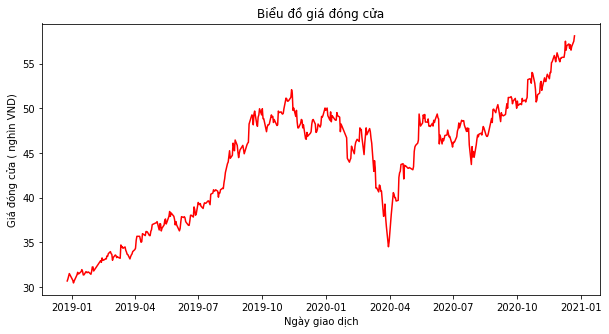

In [16]:
# Vẽ biểu đồ giá đóng cửa 
plt.figure(figsize=(10,5))
plt.plot(df1['Close'],label='Giá thực tế',color='red')
plt.title('Biểu đồ giá đóng cửa')
plt.xlabel('Ngày giao dịch')
plt.ylabel('Giá đóng cửa ( nghìn VND)')
plt.show()

Từ biểu đồ giá đóng cửa trong giai đoạn từ cuối năm 2018 tới cuối năm 2020 của mã FPT, ta thấy:
+ Trong giai đoạn này FPT tăng trưởng phải gọi là thần tốc mặc dù chịu ảnh hưởng k nhỏ bởi đại dịch toàn cầu, giá tăng từ xấp xỉ 30 nghìn VND vào cuối năm 2018 tới gần 60 nghìn VND vào thời điểm tháng 12 năm 2020 ( tăng gần 100% )
+ Thời điểm trước đại dịch FPT đã tăng mạnh lên tới gần 55 nghìn VND/1cp vào tháng 11 năm 2019, khi dịch Covid 19 ập tới, FPT cũng đã bị giảm xuống dưới 35 nghìn VND/1cp vào cuối tháng 3 năm 2020
+ Sau đó cùng với nhịp hồi phục của thị trường, FPT đã xuất sắc tăng mạnh lên mức giá 58.1 VND vào ngày 22/12/2020

In [17]:
# Chia tập dữ liệu ra thành 2 phần train và test để đánh giá hiệu suất của mô hình học máy trên tập dữ liệu

data = df1.values
train_data = data[:400]
test_data = data[400:]

In [18]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
# MinmaxScaler sẽ điều chỉnh dữ liệu: giá trị nhỏ nhất sẽ là 0, giá trị lớn nhất sẽ là 1, các giá trị khác sẽ theo tỷ lệ giữa 0 và 1
sc_train = sc.fit_transform(data)

In [41]:
# Ý tưởng của mô hình là sử dụng giá của 40 ngày liên tục để dự đoán giá của ngày tiếp theo
x_train, y_train = [],[]
for i in range(10,len(train_data)):
    x_train.append(sc_train[i-10:i,0])
    y_train.append(sc_train[i,0])

=> x_train sẽ bao gồm các mảng, mỗi bảng sẽ bao gồm 40 giá đóng cửa liên tục
    y_train sẽ bao gồm 1 danh sách giá đóng cửa của ngày hôm sau tương ứng với mỗi mảng của x_train

In [42]:
# Sắp xếp dữ liệu thành 1 mảng
x_train = np.array(x_train)
y_train = np.array(y_train)

# xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

In [43]:
import os
# Bao gồm 5 lớp mô hình
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential() # Lớp đầu vào input, tạo lớp mạng cho dữ liệu đầu vào
model.add(LSTM(units=128, input_shape=(x_train.shape[1],1), return_sequences=True)) # Mô tả thông tin của đầu vào 
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Lớp dropout sẽ random đặt 1 số giá trị trong lúc training về bằng 0 để buộc cho máy học phải học lại, tránh tình trạng overfit ( học tủ )
model.add(Dense(units=1)) # Lớp output với đầu ra 1 chiều
model.compile(loss="mean_absolute_error", optimizer='adam') # hàm sai số loss sẽ đo sai số tuyệt đối trung bình
save_model = "C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán/model6.hdf5" # sau khi training sẽ lưu vào file dạng HDF5

best_model = ModelCheckpoint( monitor='loss', verbose=1, save_best_only=True, mode="min",filepath=save_model) # Training tìm ra mô hình huấn luyện tốt nhất và chỉ lưu duy nhất 1 kết quả
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.23664, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 3s - loss: 0.2366 - 3s/epoch - 342ms/step
Epoch 2/100

Epoch 2: loss improved from 0.23664 to 0.11311, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.1131 - 117ms/epoch - 15ms/step
Epoch 3/100

Epoch 3: loss improved from 0.11311 to 0.09344, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.0934 - 126ms/epoch - 16ms/step
Epoch 4/100

Epoch 4: loss improved from 0.09344 to 0.07596, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.0760 - 115ms/epoch - 14ms/step
Epoch 5/100

Epoch 5: loss improved from 0.07596 to 0.06840, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.0684 - 116ms/epoch - 15ms/step
Epoch 6/100

Epoch 6: loss did 

In [44]:
# Sau khi tìm được mô hình tốt nhất và lưu trong file 'model6.hdf5', tải lên lại mô hình và áp dụng dự đoán vào tập train
import io
import h5py
with open('model6.hdf5', 'rb') as f:
    file_content = f.read()
    with io.BytesIO(file_content) as file:
        with h5py.File(file, 'r') as hdf:
            final_model = load_model(hdf)

y_train = sc.inverse_transform(y_train) # giá thực
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict) # Giá dự đoán

# Dùng inverse_tranform để điều chỉnh về định dạnh dữ liệu gốc vì dữ liệu đang được chuẩn hóa ở dạng trong khoảng từ 0 đến 1

13/13 [==============================] - 1s 4ms/step


In [45]:
# Với tập test làm tương tự như tập train
test = df1[len(train_data)-10:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(10,test.shape[0]):
    x_test.append(sc_test[i-10:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


# dữ liệu test
y_test = data[400:] # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) # giá dự đoán

4/4 [==============================] - 0s 4ms/step


# Độ chính xác của mô hình

C:\Users\DD\AppData\Local\Temp\ipykernel_15280\428957321.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['dự đoán'] = y_train_predict
C:\Users\DD\AppData\Local\Temp\ipykernel_15280\428957321.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict


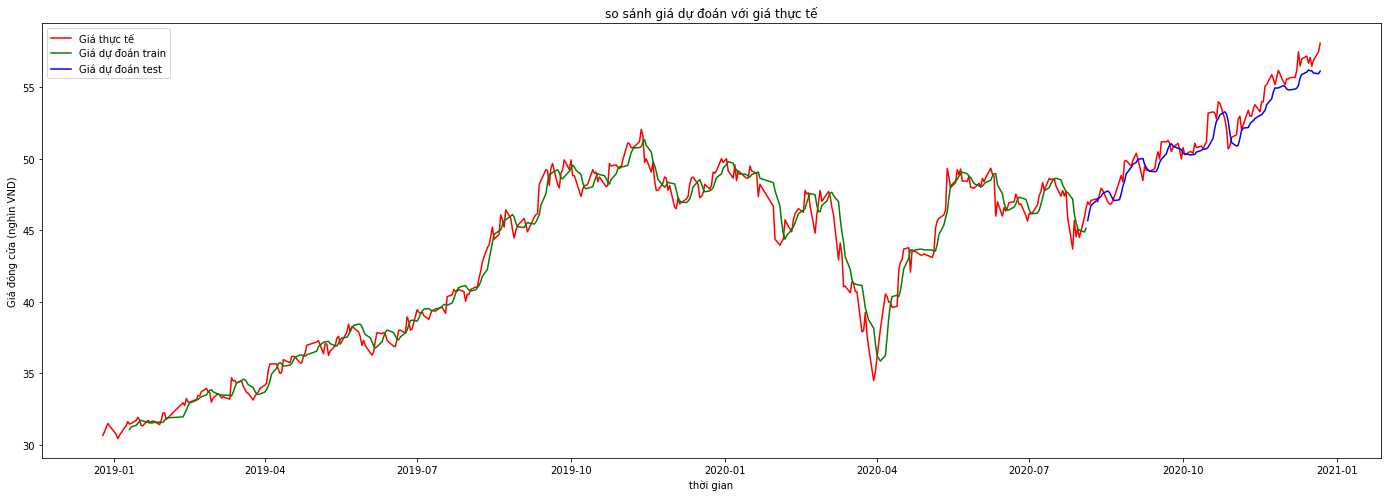

In [46]:
train_data1 = df1[10:400]
test_data1 = df1[400:]

plt.figure(figsize=(24,8))

plt.plot(df1,label='Giá thực tế',color='red')


train_data1['dự đoán'] = y_train_predict

plt.plot(train_data1['dự đoán'], label='Giá dự đoán train', color='green')


test_data1['Dự đoán'] = y_test_predict
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')

plt.title("so sánh giá dự đoán với giá thực tế")

plt.xlabel('thời gian')

plt.ylabel('Giá đóng cửa (nghìn VND)')
plt.legend()

plt.show()

In [47]:
#r2
print('Độ phù hợp của tập train: ',r2_score(y_train, y_train_predict))

#mae
print('Sai số tuyệt đối trung bình tập train: ',mean_absolute_error(y_train,y_train_predict))

#mape
print('Phần trăm sai số tuyệt đối trung bình tập train: ',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp của tập train:  0.9736734812254098
Sai số tuyệt đối trung bình tập train:  0.6705334646762947
Phần trăm sai số tuyệt đối trung bình tập train:  0.0157265246749372


In [48]:
train_data1

,Close,dự đoán
Date,,
2019-01-10,31.45,31.073490
2019-01-11,31.49,31.247082
2019-01-14,31.71,31.372917
2019-01-15,31.93,31.493320
2019-01-16,31.75,31.634722
...,...,...
2020-07-29,44.55,45.590359
2020-07-30,45.15,45.139992
2020-07-31,44.50,45.008636


In [49]:
#r2
print('Độ phù hợp của tập test: ',r2_score(y_test, y_test_predict))

#mae
print('Sai số tuyệt đối trung bình tập test: ',mean_absolute_error(y_test,y_test_predict))

#mape
print('Phần trăm sai số tuyệt đối trung bình tập train: ',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp của tập test:  0.9124758062120101
Sai số tuyệt đối trung bình tập test:  0.7186662693216346
Phần trăm sai số tuyệt đối trung bình tập train:  0.013646756591276373


In [50]:
test_data1

,Close,Dự đoán
Date,,
2020-08-05,47.0,45.687172
2020-08-06,46.8,46.310619
2020-08-07,47.1,46.752617
2020-08-10,47.2,47.058792
2020-08-11,47.0,47.243103
...,...,...
2020-12-16,57.1,56.168159
2020-12-17,56.5,56.167393
2020-12-18,56.9,56.011978


Mô hình LSTM đưa ra dự đoán biến động giá của mã chứng khoán FPT với độ phù hợp khá cao 97,3% với tập train và 91.2% với tập test



Cũng như những bài phân tích của những mã khác, thị trường chứng khoán còn rất nhiều yếu tố khác nhau có thể tác động tới xu hướng biến động của giá cổ phiếu cũng như độ sai số của mô hình, vì vậy các nhà đầu tư chỉ nên xem mô hình như 1 kênh tham khảo và có những nhận định kĩ lưỡng trước khi đưa ra quyết định đầu tư